In [2]:

from scipy.io import loadmat
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import scipy.linalg as la
import scipy.signal as signal
from scipy.interpolate import pchip
from scipy.fftpack import ifft, fft
from scipy.optimize import minimize
import sympy as sp
from numpy import pi, sin


# Problem 1


## Loading data

In [3]:
# MY LAPTOP:
wbv6 = loadmat(r"C:\Users\user\Documents\MEng Mechanical\Honours Modules\MEV 781\Assignment 3\wbvdata.mat")
wbv9 = loadmat(r"C:\Users\user\Documents\MEng Mechanical\Honours Modules\MEV 781\Assignment 3\wbvdatafor9mins\wbvdata.mat")

# Seat accelerometer x-axis
wbv6_x_seat = wbv6['d2x']
# Seat accelerometer y-axis
wbv6_y_seat = wbv6['d2xx']
# Seat accelerometer z-axis
wbv6_z_seat = wbv6['d2xxx']
# Floor accelerometer z-axis
wbv6_z_floor = wbv6['d2xxxx']

# Seat accelerometer x-axis
wbv9_x_seat = wbv9['d2x']
# Seat accelerometer y-axis
wbv9_y_seat = wbv9['d2xx']
# Seat accelerometer z-axis
wbv9_z_seat = wbv9['d2xxx']
# Floor accelerometer z-axis
wbv9_z_floor = wbv9['d2xxxx']

t_6 = np.linspace(0, (6.5*60), len(wbv6_x_seat))
t_9 = np.linspace(0, (9*60), len(wbv9_x_seat))



## Part A

### Wk filter

In [8]:

def fft(Signal, Fs):
    n = len(Signal) 
    FFT_Freq = np.fft.fftfreq(n, 1/Fs)
    FFT_Freq = FFT_Freq[0 : int(n/2)]
    FFT_Vals = np.fft.fft(Signal)/n
    FFT_ValsPlot = np.abs(FFT_Vals)
    FFT_ValsPlot[:int(n/2)] = 2 * FFT_ValsPlot[:int(n/2)]
    return FFT_Freq, FFT_ValsPlot[0:int(n/2)]

def wkfilter(a, fs):
    f1 = 0.4; w1 = 2*np.pi*f1;
    f2 = 100; w2 = 2*np.pi*f2;
    f3 = 12.5; w3 = 2*np.pi*f3;
    f4 = 12.5; w4 = 2*np.pi*f4; Q4 = 0.63;
    f5 = 2.37; w5 = 2*np.pi*f5; Q5 = 0.91;
    f6 = 3.35; w6 = 2*np.pi*f6; Q6 = 0.91;
    
    # Frequency Range
    f = np.arange(0, fs, 0.01)
    w = 2*np.pi*f
    
    # High pass filter
    Bh = np.array([1, 0, 0])
    Ah = np.array([1, np.sqrt(2)*w1, w1**2])
    Hh = signal.freqs(Bh, Ah, w)
    
    # Low pass filter
    Bl = np.array([1])
    Al = np.array([1/(w2**2), np.sqrt(2)/w2, 1])
    Hl = signal.freqs(Bl, Al, w)
    
    # Acceleration-velocity transition
    Bt = np.array([1/w3, 1])
    At = np.array([1/(w4**2), 1/(Q4*w4), 1])
    Ht = signal.freqs(Bt, At, w)
    
    # Upward Step
    Bs = ((w5/w6)**2)*np.array([1/(w5**2), 1/(Q5*w5), 1])
    As = np.array([1/(w6**2), 1/(Q6*w6), 1])
    Hs = signal.freqs(Bs, As, w)
    
    # Creating the Filter
    Bbl = np.convolve(Bh, Bl); Bwt = np.convolve(Bt, Bs); B = np.convolve(Bbl, Bwt);
    Abl = np.convolve(Ah, Al); Awt = np.convolve(At, As); A = np.convolve(Abl, Awt);
    H = signal.freqs(B, A, w);
    n = len(a)
    
    # Interpolation range constructed to be same length as fftsig
    interpolation_range = np.linspace(0, w[-1], int(len(a)/2))
    
    # Weighting Curve
    Hval = interp1d(w, H[1], 'cubic')(interpolation_range)
    fftsig = np.fft.fft(a, n)
    fftsig = (fftsig)*2/n
    fftsig = fftsig[0:int(n/2)]
    fft_filtered = fftsig*Hval
    filtered = ((fft_filtered)/2)*n
    filtered_sig = np.fft.ifft(filtered)
    filtered_sig = np.real(filtered_sig)
    step = (1/fs)*2
    time_range = []
    t_i = 0
    for i in range(int(len(a)/2)):
        time_range.append(t_i)
        t_i = t_i + step
    
    return f, np.abs(H[1]), time_range, filtered_sig

def nextpow2(x):
    res = np.ceil(np.log2(x))
    return res.astype('int')


### Wk filter on simulated signal

Weight Range Length :  50000
Weight Curve Length :  50000

Original Time Length :  2500
Original Sig Length :  2500

Filtered Time Length :  1250
Filtered Sig Length :  1250


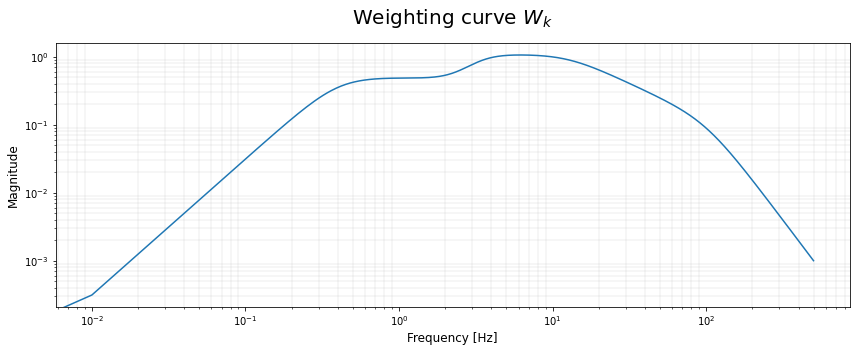

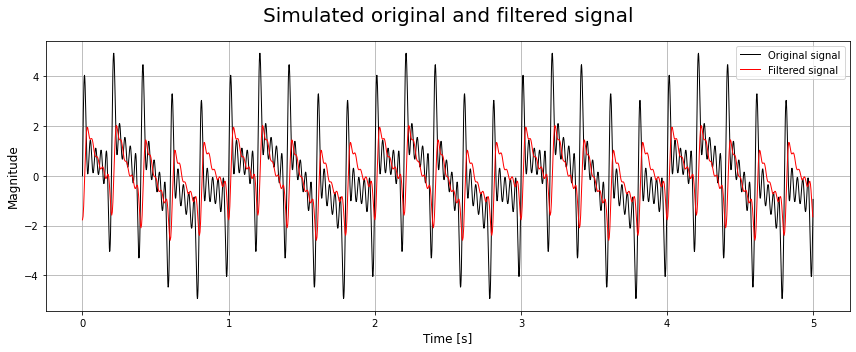

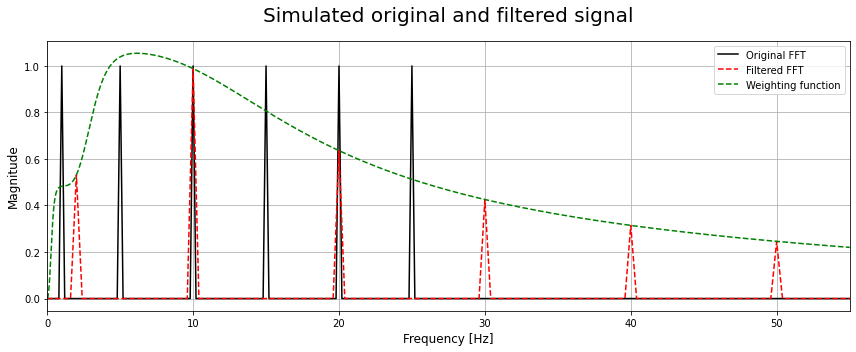

In [28]:

fs = 500
t_simulated = np.arange(0, 5, 1/fs)

simulated_signal = (sin(2*np.pi*t_simulated*1)  + sin(2*np.pi*t_simulated*5) + sin(2*np.pi*t_simulated*10) + sin(2*np.pi*t_simulated*15) 
                    + sin(2*np.pi*t_simulated*20) + sin(2*np.pi*t_simulated*25))

weight_range , weight_curve, time_range, filtered_sig = wkfilter(simulated_signal, fs)

print('Weight Range Length : ', len(weight_range))
print('Weight Curve Length : ', len(weight_curve))
print('')
print('Original Time Length : ', len(t_simulated))
print('Original Sig Length : ', len(simulated_signal))
print('')
print('Filtered Time Length : ', len(time_range))
print('Filtered Sig Length : ', len(filtered_sig))

plt.figure(1, figsize = (12, 5))
plt.title('Weighting curve $W_k$', fontsize = 20, y=1.05)
plt.loglog(weight_range, weight_curve)
plt.xlabel('Frequency [Hz]', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.grid(which='minor', linewidth=0.2)
plt.tight_layout()

fft_orig = fft(simulated_signal, fs)
fft_fil = fft(filtered_sig, fs)

plt.figure(2, figsize=(12, 5))
plt.title('Simulated original and filtered signal', fontsize = 20, y=1.05)
plt.plot(t_simulated, simulated_signal, color="k", linewidth = 1, label='Original signal')
plt.plot(time_range, filtered_sig, "r-", linewidth = 1, label='Filtered signal')
plt.legend(loc='best')
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.grid()
plt.tight_layout()

plt.figure(3, figsize=(12, 5))
plt.title('Simulated original and filtered signal', fontsize=20, y=1.05)
plt.xlabel('Frequency [Hz]', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.plot(fft_orig[0], fft_orig[1], color="k", label='Original FFT')
plt.plot(fft_fil[0], fft_fil[1], "r--", label='Filtered FFT')
plt.plot(weight_range, weight_curve, "g--", label = 'Weighting function')
plt.xlim([0, 55])
plt.legend(loc='best')
plt.grid()
plt.tight_layout()




## Part B


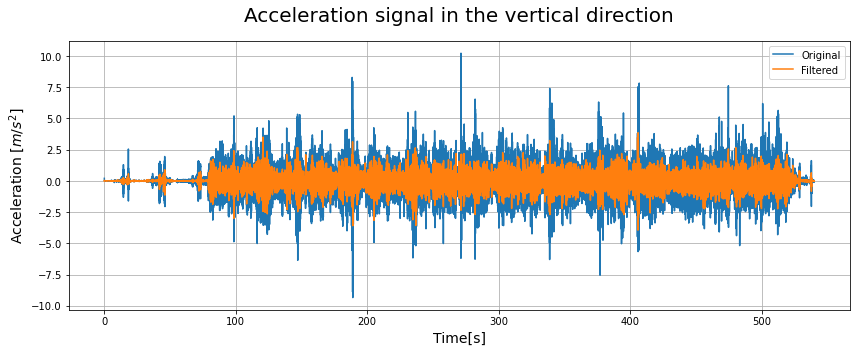

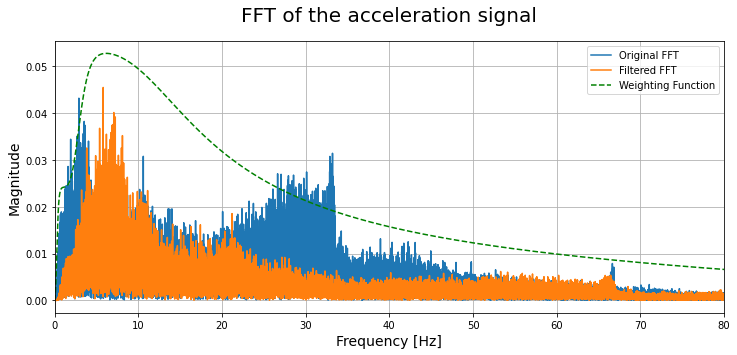

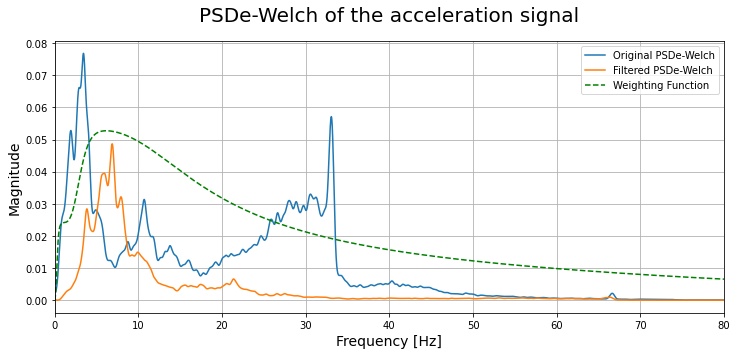

In [118]:

fs = 160 # Given sampling freq

# 6.5 MINUTES:
# seat_sig = wbv6_z_seat.flatten()
# 9 MINUTES:
seat_sig = wbv9_z_seat.flatten()

filtered_seat_sig = wkfilter(seat_sig, fs)

plt.figure(1, figsize=(12, 5))
plt.title('Acceleration signal in the vertical direction', fontsize=20, y=1.05)

# 6.5 MINUTES:
# plt.plot(t_6, seat_sig, label = 'Original')
# 9 MINUTES:
plt.plot(t_9, seat_sig, label = 'Original')

plt.plot(filtered_seat_sig[2], filtered_seat_sig[3], label = 'Filtered')
plt.legend(loc='best')
plt.xlabel('Time[s]', fontsize = 14)
plt.ylabel(r'Acceleration [$m/s^2$]', fontsize=14)
plt.grid()
plt.tight_layout()

##########################################################################################################################

fft_orig = fft(seat_sig, fs)
fft_fil = fft(filtered_seat_sig[3], fs)

plt.figure(2, figsize=(12, 5))
plt.title('FFT of the acceleration signal', fontsize=20, y=1.05)
plt.plot(fft_orig[0], fft_orig[1], label = 'Original FFT')
plt.plot(fft_fil[0], fft_fil[1], label = 'Filtered FFT')
plt.plot(filtered_seat_sig[0], filtered_seat_sig[1]/20, 'g--', label = 'Weighting Function')
plt.xlabel('Frequency [Hz]', fontsize = 14)
plt.ylabel('Magnitude', fontsize = 14)
plt.xlim([0, 80])
plt.grid()
plt.legend(loc='best')

##########################################################################################################################

window_size = 512
w = signal.get_window('hanning', window_size)
Nfft = 2**nextpow2(len(seat_sig))

f_psd_orig, Pxx_orig = signal.welch(seat_sig, fs, window = w, nfft = Nfft)
A_rms_orig = np.sqrt(Pxx_orig)

f_psd_filt, Pxx_filt = signal.welch(filtered_seat_sig[3], fs, window = w, nfft = Nfft)
A_rms_filt = np.sqrt(Pxx_filt)

# Should be plotting the A values, so just mention that plot is scaled.
plt.figure(3, figsize=(12, 5))
plt.title('PSDe-Welch of the acceleration signal', fontsize=20, y=1.05)
plt.plot(f_psd_orig, Pxx_orig, label = 'Original PSDe-Welch')
plt.plot(f_psd_filt, Pxx_filt, label = 'Filtered PSDe-Welch')
plt.plot(filtered_seat_sig[0], filtered_seat_sig[1]/20, 'g--',label = 'Weighting Function')
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.xlim([0, 80])
plt.legend(loc='best')
plt.grid()

f_128, Pxx_128 = signal.welch(filtered_seat_sig[3], fs , window = signal.get_window('hanning',128), nfft = Nfft)
A_rms_128 = np.sqrt(Pxx_128)
f_256, Pxx_256 = signal.welch(filtered_seat_sig[3], fs , window = signal.get_window('hanning',256), nfft = Nfft)
A_rms_256 = np.sqrt(Pxx_256)



Peak Value:  3.8546972294662663
RMS Value:  0.5491458799268969
Crest Factor:  7.019441227492063

Max MTVV:  1.9125082678921035
Max MTVVrms:  1.382934657853401

VDV:  4.0514673350184935
VDV Total:  10.931539015663573
eVDV:  10.01529825736568



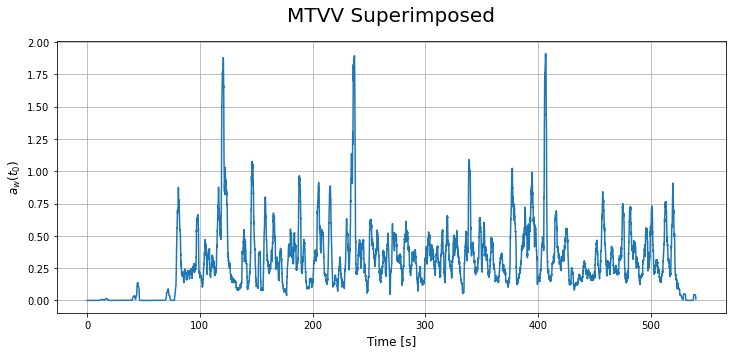

In [119]:

### Calculating MTVVs, VDV, Sed

aw = filtered_seat_sig[3] # vertical acceleration.

def peak(x):
    average = np.mean(x)
    vals = []
    for i in range(len(x)):
        vals.append(x[i]-average)
    positive = sorted(vals)[-1]
    negative = sorted(vals)[0]
    return positive, negative

def rms(x):
    squared = x**2
    rms = (np.mean(squared))**0.5
    return rms

def crest_factor(x):
    xpos = peak(x)[0]
    xrms = rms(x)
    crest = xpos/xrms
    return crest

crest = crest_factor(aw)

from scipy.integrate import trapz

awsq = aw**2
duration = 8*60*60 # T
endtime = 540 # 9 minutes

MTVVrms = []
MTVV1 = []
for i in range(int(len(awsq)-fs)):
    MTVVrms.append(rms(aw[i:i+fs]))
    MTVV1.append(np.mean(awsq[i:i+fs]))
    
MTVV = np.array([max(MTVV1), max(MTVVrms)])

VDV8 = 0
aw4 = aw**4
vdvtrap = trapz(aw4, filtered_seat_sig[2])
VDV = (vdvtrap)**(1/4)
VDV8 = 0
for i in range(int(duration/endtime)):
    VDV8 = VDV8 + VDV**4

VDV8 = VDV8**(0.25)
eVDV = (((1.4*rms(aw))**4)*(duration))**(1/4)
MTVV_range = np.linspace(0, endtime, len(MTVV1))
indexx = np.where(MTVV1 == MTVV[0])[0][0]

plt.figure(2, figsize=(12, 5))
plt.title('MTVV Superimposed', fontsize=20, y=1.05)
plt.plot(MTVV_range, MTVV1)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('$a_w(t_0)$', fontsize=12)
plt.grid()


print('Peak Value: ', abs(peak(aw)[0]))
print('RMS Value: ', rms(aw))
print('Crest Factor: ', crest)
print('')
print('Max MTVV: ', MTVV[0])
print('Max MTVVrms: ', MTVV[1])
print('')
print('VDV: ', VDV)
print('VDV Total: ', VDV8)
print('eVDV: ', eVDV)
print('')


# Problem 2

### Loading data


In [39]:
rock_drill = loadmat(r"C:\Users\user\Documents\MEng Mechanical\Honours Modules\MEV 781\Assignment 3\MEV_Assignment_3_06July_v1\DrillData.mat")

rock_drill.keys()


dict_keys(['__header__', '__version__', '__globals__', 'DrillData'])

In [40]:

print(rock_drill["DrillData"])

time = rock_drill["DrillData"][:, 0].squeeze()
print(np.shape(time))

x_acc = rock_drill["DrillData"][:, 1].squeeze()

y_acc = rock_drill["DrillData"][:, 2].squeeze()

z_acc = rock_drill["DrillData"][:, 3].squeeze()


[[ 0.00000000e+00 -4.22960725e+01  1.64954683e+01  4.35649546e+01]
 [ 1.95312500e-04  9.30513594e+00  1.22658610e+01  1.02356495e+02]
 [ 3.90625000e-04  1.94561933e+01  8.45921449e+00  1.23927492e+02]
 ...
 [ 1.59994141e+01  3.55287009e+01 -1.52265861e+01 -2.49546828e+01]
 [ 1.59996094e+01  1.98791541e+01  8.12084591e+01 -6.68277945e+01]
 [ 1.59998047e+01  0.00000000e+00  1.24350453e+02 -2.07250755e+01]]
(81920,)


In [42]:
def fft(Signal, Fs):
    n = len(Signal) 
    FFT_Freq = np.fft.fftfreq(n, 1/Fs)
    FFT_Freq = FFT_Freq[0 : int(n/2)]
    FFT_Vals = np.fft.fft(Signal)/n
    FFT_ValsPlot = np.abs(FFT_Vals)
    FFT_ValsPlot[:int(n/2)] = 2 * FFT_ValsPlot[:int(n/2)]
    return FFT_Freq, FFT_ValsPlot[0:int(n/2)]

## Part A





In [72]:
import PyOctaveBand
import numpy as np
import scipy.io.wavfile

In [112]:
def HAV(Ax,Ay,Az):
    sampling_freq = 5000
    _, _, xb = PyOctaveBand.octavefilter(Ax, fs=sampling_freq, fraction=3, order=12, limits=[6.3, 1250], show=1, sigbands=1)
    _, _, yb = PyOctaveBand.octavefilter(Ay, fs=sampling_freq, fraction=3, order=12, limits=[6.3, 1250], show=0, sigbands=1)
    _, _, zb = PyOctaveBand.octavefilter(Az, fs=sampling_freq, fraction=3, order=12, limits=[6.3, 1250], show=0, sigbands=1)
    
    w_hi = np.array([0.727,0.873,0.951,0.958,0.895,0.782,0.647,0.519,0.411,0.324,0.256,0.202,
                 0.160,0.127,0.101,0.0799,0.0634,0.0503,0.0398,0.0314,0.0245,0.0186,0.0135,0.00894])
    
    final_vals_x = []
    final_vals_y = []
    final_vals_z = []
    for i in range(len(xb)):
        x_vals = ((xb[i]*w_hi[i])**2)[:81920]
        y_vals = ((yb[i]*w_hi[i])**2)[:81920]
        z_vals = ((zb[i]*w_hi[i])**2)[:81920]
        final_vals_x.append(x_vals)
        final_vals_y.append(y_vals)
        final_vals_z.append(z_vals)

    a_hwx = np.sqrt(sum(final_vals_x))
    a_hwy = np.sqrt(sum(final_vals_y))
    a_hwz = np.sqrt(sum(final_vals_z))

    a_hv = sum(np.sqrt(a_hwx**2 + a_hwy**2 + a_hwz**2))/len(a_hwx)
    A8 = a_hv*np.sqrt(4/8)
    
    return a_hwx,a_hwy,a_hwz,A8

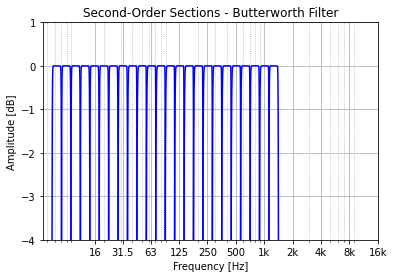

14.690291354394827


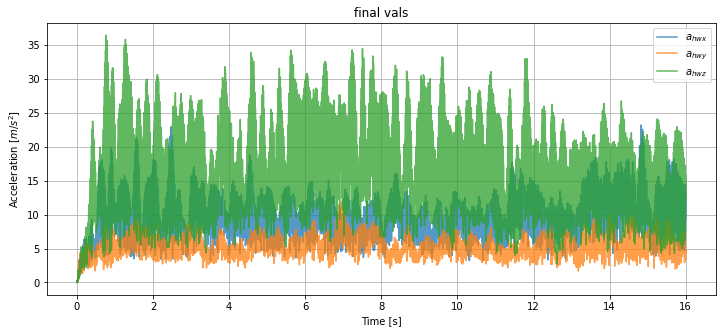

In [113]:
a_hwx,a_hwy,a_hwz,A8 = HAV(x_acc,y_acc,z_acc)
print(A8)
plt.figure(1, figsize = (12, 5))
plt.title('final vals')
plt.plot(time[:81920],a_hwx,alpha=0.75,label='$a_{hwx}$')
plt.plot(time[:81920],a_hwy,alpha=0.75,label='$a_{hwy}$')
plt.plot(time[:81920],a_hwz,alpha=0.75,label='$a_{hwz}$')
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [$m/s^2$]")
plt.grid()
plt.show()

## Part B


In [104]:

def fft(Signal, Fs):
    n = len(Signal) 
    FFT_Freq = np.fft.fftfreq(n, 1/Fs)
    FFT_Freq = FFT_Freq[0 : int(n/2)]
    FFT_Vals = np.fft.fft(Signal)/n
    FFT_ValsPlot = np.abs(FFT_Vals)
    FFT_ValsPlot[:int(n/2)] = 2 * FFT_ValsPlot[:int(n/2)]
    return FFT_Freq, FFT_ValsPlot[0:int(n/2)]

def whfilter(a, fs):
    f1=6.31;
    f2=1258.9;
    f3=15.915;
    f4=15.915;

    Q1=0.71;
    Q2=0.64;

    K=1;

    # Frequency Range
    f = np.arange(0, fs, 0.01)
    w = 2*np.pi*f
    
    ##########################################################################################################
    # Band-limiting filter
    Bb = np.array([4*pi**2 * f2**2, 0, 0])
    Ab = np.convolve(np.array([1, 2*pi*f1/Q1, 4*pi**2 * f1**2]), np.array([1, 2*pi*f2/Q1, 4*pi**2 * f2**2]))
    Hb = signal.freqs(Bb, Ab, w)
    
    ##########################################################################################################
    # Frequency weighting filter
    Bw = np.array([2*pi * K * f4**2, 2*pi * K * f4**2 * 2*pi * f3])
    Aw = np.array([f3,  2*pi * f4*f3/Q2, 4*pi**2 * f4**2 * f3])
    Hw = signal.freqs(Bw, Aw, w)    
        
    ##########################################################################################################
    # Creating the filter
    B = np.convolve(Bb, Bw)
    A = np.convolve(Ab, Aw)
    H = signal.freqs(B, A, w)
    n = len(a)
    
    # Interpolation range constructed to be same length as fftsig
    interpolation_range = np.linspace(0, w[-1], int(len(a)/2))
    
    # Weighting Curve
    Hval = interp1d(w, H[1], 'cubic')(interpolation_range)
    fftsig = np.fft.fft(a, n)
    fftsig = (fftsig)*2/n
    fftsig = fftsig[0:int(n/2)]
    fft_filtered = fftsig*Hval
    filtered = ((fft_filtered)/2)*n
    filtered_sig = np.fft.ifft(filtered)
    filtered_sig = np.real(filtered_sig)
    step = (1/fs)*2
    time_range = []
    t_i = 0
    for i in range(int(len(a)/2)):
        time_range.append(t_i)
        t_i = t_i + step
    
    return f, np.abs(H[1]), time_range, filtered_sig
    
    
def nextpow2(x):
    res = np.ceil(np.log2(x))
    return res.astype('int')


Weight Range Length :  8192000
Weight Curve Length :  8192000

Original Time Length :  30000
Original Sig Length :  30000

Filtered Time Length :  40960
Filtered Sig Length :  40960


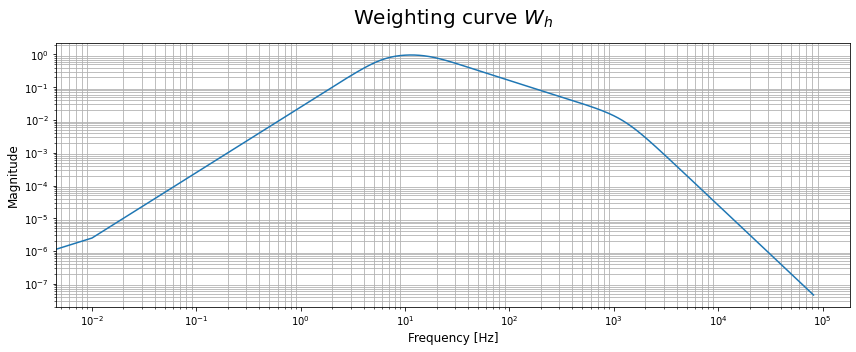

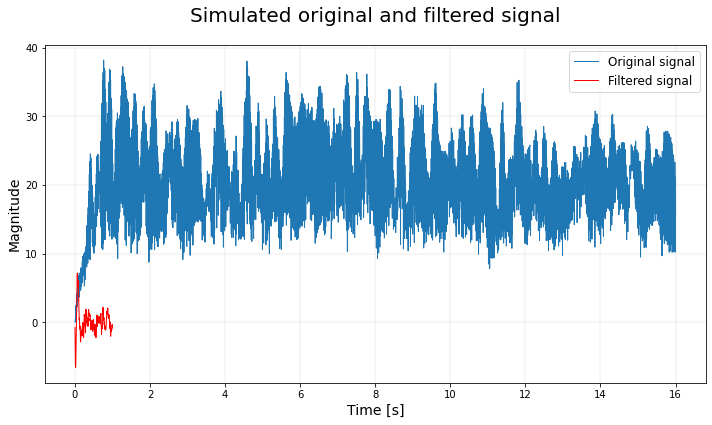

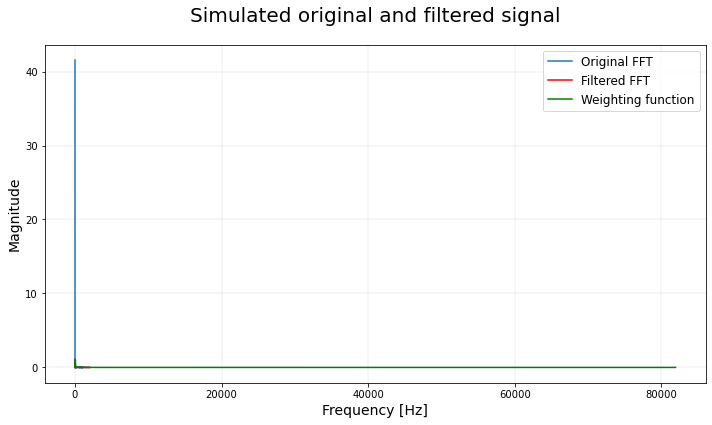

In [106]:

a_wh = np.sqrt(a_hwx**2+a_hwy**2+a_hwz**2)
time = np.linspace(0,16,len(a_wh))
sampling_freq = len(a_wh)

weight_range, weight_curve, time_range, filtered_sig = whfilter(a_wh, sampling_freq)

print('Weight Range Length : ', len(weight_range))
print('Weight Curve Length : ', len(weight_curve))
print('')
print('Original Time Length : ', len(t_simulated))
print('Original Sig Length : ', len(simulated_signal))
print('')
print('Filtered Time Length : ', len(time_range))
print('Filtered Sig Length : ', len(filtered_sig))

plt.figure(1, figsize = (12, 5))
plt.title('Weighting curve $W_h$', fontsize = 20, y=1.05)
plt.loglog(weight_range, weight_curve)
plt.xlabel('Frequency [Hz]', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.grid(which='minor')
plt.tight_layout()

fft_orig = fft(a_wh, fs)
fft_fil = fft(filtered_sig, fs)

plt.figure(2, figsize=(10, 6))
plt.title('Simulated original and filtered signal', fontsize = 20, y=1.05)
plt.plot(time, a_wh, linewidth = 1, label='Original signal')
plt.plot(time_range, filtered_sig, linewidth = 1, color="r", label='Filtered signal')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.grid(linewidth=0.2)
plt.tight_layout()

plt.figure(3, figsize=(10, 6))
plt.title('Simulated original and filtered signal', fontsize=20, y=1.05)
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.plot(fft_orig[0], fft_orig[1], label='Original FFT')
plt.plot(fft_fil[0], fft_fil[1], "r", label='Filtered FFT')
plt.plot(weight_range, weight_curve, "g", label = 'Weighting function')
plt.legend(loc='best', fontsize=12)
plt.grid(linewidth=0.2)
plt.tight_layout()


## Part C


In [116]:

def rms(x):
    squared = x**2
    rms = (np.mean(squared))**0.5
    return rms
print('Awx RMS value: ', rms(a_hwx))
print('Awy RMS value: ', rms(a_hwy))
print('Awz RMS value: ', rms(a_hwz))


Awx RMS value:  10.327953429972005
Awy RMS value:  5.547424370621675
Awz RMS value:  18.038649941602426


## Part D

In [117]:

a_wh = sum(np.sqrt(a_hwx**2+a_hwy**2+a_hwz**2))/len(a_hwx)
print(a_wh)
A8 = a_wh*np.sqrt(4/8)
print(A8)

20.775209268597386
14.690291354394827


# Problem 3


Gautrain lv change:  -8.109302162163289 dBV
Adjustment:  -8 dBV
Total Adjustment:  -16.10930216216329 dBV
Accept Value:  59.959579308770856 dBV


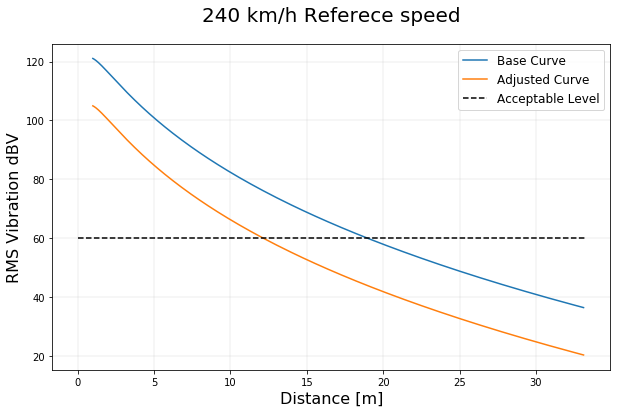

In [4]:

Gautrain_speed = 160
lv = 20*np.log(Gautrain_speed/240)
                     
RMS_base = np.array([[2, 120], [3, 119], [4, 117], [5, 116], [6, 115], [7, 114], [8, 113.5], [9, 113], [10, 112], [20, 107], [30, 103], [40, 102], [50, 100], [60, 98], [70, 96], [80, 93], [90, 92], [100, 90]])
RMS = np.array([[2, 120], [3, 119], [4, 117], [5, 116], [6, 115], [7, 114], [8, 113.5], [9, 113], [10, 112], [20, 107], [30, 103], [40, 102], [50, 100], [60, 98], [70, 96], [80, 93], [90, 92], [100, 90]])

adjust = 10 + 10 + 10 - 15 - 10 - 13
RMS_change = lv + adjust
for i in range(RMS.shape[0]):
    RMS[i, 1] = RMS[i, 1] + RMS_change

xlog10_base = np.log10(RMS_base[:, 0])
Y_base = RMS_base[:, 1]
N = 2
coeff_base = np.polyfit(xlog10_base, Y_base, N)
xloge_base = np.linspace(0, 3.5, 200)
Ye_base = np.polyval(coeff_base, xloge_base)

xlog10 = np.log10(RMS[:, 0])
Y = RMS[:, 1]
N = 2
coeff = np.polyfit(xlog10, Y, N)
xloge = np.linspace(0, 3.5, 200)
Ye = np.polyval(coeff, xloge)

accept_val = Ye[np.where(Ye<=60)[0][0]]
print('Gautrain lv change: ', lv, 'dBV')
print('Adjustment: ', adjust, 'dBV')
print('Total Adjustment: ', RMS_change, 'dBV')
print('Accept Value: ', accept_val, 'dBV')

plt.figure(1, (10, 6))
plt.title('240 km/h Referece speed', fontsize = 20, y = 1.05)
plt.plot(np.exp(xloge_base), Ye_base, label='Base Curve')
plt.plot(np.exp(xloge), Ye, label='Adjusted Curve')
plt.plot([0,33.2], [accept_val, accept_val], 'k--', label='Acceptable Level')
plt.xlabel('Distance [m]', fontsize=16)
plt.ylabel('RMS Vibration dBV', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(linewidth=0.2)
